https://github.com/martinarjovsky/WassersteinGAN

https://vincentherrmann.github.io/blog/wasserstein/

https://github.com/martinarjovsky/WassersteinGAN/issues/2

https://github.com/caogang/wgan-gp/blob/master/gan_cifar10.py

# To do:

* Clip and then intorudce logs (should go to -17,9)
* Overfit small dataset
* Add confidence intervals to (mean and std)
* Upload redshift 5
* Fix sns denisty plots
* Check for overfitting
* Play around with optimizers
* Clean code, integrate transformations
* Revise and change architecture (less convs, polling, FC), add convolution after ReLU in generator
* Mean and standard errors of power spectrums
* Increase channels
* Bigger cubes with no padding
* Use other standarizations of data
* Gradient penalty instead of weight clamping
* Locally connected layers
* Weight initialization
* Mini batch discrimination

In [1]:
from __future__ import print_function
#import argparse
import os
import random
import numpy as np

#import torch

import torch.multiprocessing as mp
mp.set_start_method('spawn')

import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable, grad

import matplotlib.pyplot as plt
%matplotlib inline

import h5py

import itertools
from matplotlib.ticker import MultipleLocator
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from matplotlib.ticker import MultipleLocator
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import colors
import matplotlib as mpl
import timeit

import seaborn as sns

ngpu = 1   

from power_spectrum_utils import power_spectrum_np
from wgan_utils import define_test, check_coords, get_samples
#from data_utils import get_max_cube, get_min_cube, get_mean_cube, get_stddev_cube
from plot_utils import hist_plot, plot_loss, plot_means

C:\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
#mean_5=get_mean_cube('../../../../../','5.0')
#std_5=get_stddev_cube('../../../../../','5.0',mean_5)
mean_5=14592.24
#mean_5=0
std_5=922711.56
max_5=4376932000
mask_value=10**2

In [3]:
#get_ipython().run_line_magic('run', '../mmd_gan/utils/power_spectrum_utils.py')
#get_ipython().run_line_magic('run', '../mmd_gan/utils/plot_utils.py')

def moving_average(data_set, periods=3):
    weights = np.ones(periods) / periods
    return np.convolve(data_set, weights, mode='valid')



def plot_power_spec(real_cube,        # should be inverse_transformed
                    generated_cube,   # should be inverse_transformed
                    raw_cube_mean,
                   s_size,
                    threads=1, 
                    MAS="CIC", 
                    axis=0, 
                    BoxSize=75.0/2048*64):
    """Takes as input;
    - Real cube: (batch_size x 1 x n x n x n) torch cuda FloatTensor,
    - Generated copy: (batch_size x 1 x n x n x n) torch cuda FloatTensor,
    - constant assignments: threads, MAS, axis, BoxSize.
    
    Returns;
    - Power spectrum plots of both cubes
    in the same figure.
    """
    real_cube = real_cube.reshape(-1,
                                  1,
                                  real_cube.shape[2],
                                  real_cube.shape[2],
                                  real_cube.shape[2])
    generated_cube = generated_cube.reshape(-1,
                                            1,
                                            generated_cube.shape[2],
                                            generated_cube.shape[2],
                                            generated_cube.shape[2])
    
    #print("number of samples of real and generated cubes = " + str(real_cube.shape[0]))

    plt.figure(figsize=(16,8))
    
    for cube_no in range(real_cube.shape[0]):
        
        delta_real_cube = real_cube[cube_no][0]
        delta_gen_cube = generated_cube[cube_no][0]
        
        Pk_real, k_real = power_spectrum_np(cube = delta_real_cube, mean_raw_cube = raw_cube_mean, SubBoxSize=s_size)
        Pk_gen,  k_gen = power_spectrum_np(cube = delta_gen_cube,  mean_raw_cube = raw_cube_mean, SubBoxSize=s_size)
    
        plt.plot(np.log(k_real), np.log(Pk_real), color="b", 
                 alpha = 0.8, label="Real")
        plt.plot(np.log10(k_gen), np.log(Pk_gen), color="r",
                 alpha = 0.8, label="Generated")
        
        plt.rcParams["font.size"] = 16
        plt.title("Power Spectrum Comparison - (Blue: Real, Red: Noise-Generated)")
        plt.xlabel('logk')
        plt.ylabel('log(Pk.k3D)')
        #plt.xlim(0, 3)
#         plt.legend()
    
    #if save_plot:
     #   plt.savefig(redshift_fig_folder + 'powerspectrum_' + str(t) + '.png', 
      #              bbox_inches='tight')
   
    plt.show()
    #return np.log10(k_real), np.log10(k_gen)

In [4]:
class HydrogenDataset(Dataset):
    """Hydrogen Dataset"""

    def __init__(self, h5_file, s_test, s_sample, nsamples,transform, rotate):
        """
        Args:
            h5_file (string): name of the h5 file with 32 sampled cubes.
            root_dir (string): Directory with the .h5 file.
        """
        #file_size = os.path.getsize(root_dir + h5_file) / 1e6 # in MBs
        #print("The whole file size is " + str(int(file_size)) + " MBs")
        # self.subcubes = h5py.File('../data/sample_32.h5', 'r')
        self.s_test = s_test
        self.s_sample = s_sample
        self.t_coords = define_test(self.s_test,self.s_sample)
        self.nsamples = nsamples
        self.redshift = redshift
        self.transform=transform
        self.rotate=rotate
        self.file=h5_file

    def __len__(self):
        # Function called when len(self) is executed
        return self.nsamples

    def __getitem__(self, idx):
        """
        This can be implemented in such a way that the whole h5 file read 
        using h5py.File() and get_sample() function is called to return
        a random subcube. This won't increase memory usage because the
        subcubes will be read in the same way and only the batch will
        be read into memory.
        
        Here we have implemented it so that it can be used with data
        generated by get_sample() function.
        
        The output of this function is one subcube with the dimensions
        specified by get_sample() implementation.
        """
        
        sample = get_samples(file = self.file,
                            s_sample = self.s_sample,
                             nsamples = 1,
                             test_coords = self.t_coords)
        sample=sample.mean(axis=2)
        
        if self.rotate==True:
            t=random.randint(1,4)
            if t==4:
                sample=sample
            else:
                sample=np.rot90(sample, t, random.choice([(0,1), (1,0)]))
        
        if self.transform=='max':
            sample = sample / self.max_cube
        if self.transform=='normalize':
            sample = (sample-mean_5)/std_5
        if self.transform=='clip_log':
            sample[sample <10**2]==0
            sample[sample > 3*std_5]==3*std_5
            sample=np.log(sample+1)
            
            
        if self.transform=='log':
            sample= np.log(sample)
        if self.transform=='root':
            sample = (sample)**(1/4)
        if self.transform=='log_max':
            sample=np.log(sample)/np.log(max_5)
        #print(np.array(sample).shape)
    
        sample=sample.reshape((1, self.s_sample, self.s_sample))

        return torch.tensor(sample)

In [5]:
def visualize2d(real, fake, save=''):
    max_=np.log(2.5*(10**6))
    max_=1
    #cols=real.shape[0]//2
    cols=8
    rows=2
    
    fig, axes = plt.subplots(nrows=2, ncols=cols, figsize=(16,4))
    
    for ax, row in zip(axes[:,0], ['Generated', 'Real']):
        ax.set_ylabel(row, rotation=90, fontsize=16)
    
    m=0
    for ax in axes.flat:
        #Plot only half of the mini-batch
        if m<cols:
            im = ax.imshow(np.log(fake[m][0]), aspect='equal', 
                       interpolation=None, vmin=0, vmax=max_)
        
        else:
            im = ax.imshow(np.log(real[m][0]), aspect='equal', 
                       interpolation=None, vmin=0, vmax=max_)
        m+=1
        ax.set_xticks([])
        ax.set_yticks([])
    #fig.subplots_adjust(right=.8)
    #cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
    #fig.colorbar(ax, cax=cbar_ax)
    fig.tight_layout() 
    if save!='':
        fig.savefig(save+'samples.png', dpi=1000)
           
    plt.show()  

In [6]:
class DCGAN_D(nn.Module):
    def __init__(self, isize, nz, nc, ndf, ngpu, n_extra_layers=0):
        super(DCGAN_D, self).__init__()
        self.ngpu = ngpu
        assert isize % 16 == 0, "isize has to be a multiple of 16"

        main = nn.Sequential()
        # input is nc x isize x isize
        main.add_module('initial_conv_{0}-{1}'.format(nc, ndf),
                        nn.Conv2d(nc, ndf, 4, 2, 1, bias=False))
        main.add_module('initial_relu_{0}'.format(ndf),
                        nn.LeakyReLU(0.2, inplace=True))
        csize, cndf = isize / 2, ndf

        # Extra layers
        for t in range(n_extra_layers):
            main.add_module('extra-layers-{0}_{1}_conv'.format(t, cndf),
                            nn.Conv2d(cndf, cndf, 3, 1, 1, bias=False))
            main.add_module('extra-layers-{0}_{1}_batchnorm'.format(t, cndf),
                            nn.BatchNorm2d(cndf))
            main.add_module('extra-layers-{0}_{1}_relu'.format(t, cndf),
                            nn.LeakyReLU(0.2, inplace=True))

        while csize > 4:
            in_feat = cndf
            out_feat = cndf * 2
            main.add_module('pyramid_{0}-{1}_conv'.format(in_feat, out_feat),
                            nn.Conv2d(in_feat, out_feat, 4, 2, 1, bias=False))
            main.add_module('pyramid_{0}_batchnorm'.format(out_feat),
                            nn.BatchNorm2d(out_feat))
            main.add_module('pyramid_{0}_relu'.format(out_feat),
                            nn.LeakyReLU(0.2, inplace=True))
            cndf = cndf * 2
            csize = csize / 2

        # state size. K x 4 x 4
        main.add_module('final_{0}-{1}_conv'.format(cndf, 1),
                        nn.Conv2d(cndf, 1, 4, 1, 0, bias=False))
        self.main = main


    def forward(self, input):
        if isinstance(input.data, torch.cuda.FloatTensor) and self.ngpu > 1:
            output = nn.parallel.data_parallel(self.main, input, range(self.ngpu))
        else: 
            output = self.main(input)
            
        output = output.mean(0)
        return output.view(1)

In [7]:
class DCGAN_G(nn.Module):
    def __init__(self, isize, nz, nc, ngf, ngpu, n_extra_layers=0):
        super(DCGAN_G, self).__init__()
        self.ngpu = ngpu
        assert isize % 16 == 0, "isize has to be a multiple of 16"

        cngf, tisize = ngf//2, 4
        while tisize != isize:
            cngf = cngf * 2
            tisize = tisize * 2

        main = nn.Sequential()
        # input is Z, going into a convolution
        main.add_module('initial_{0}-{1}_convt'.format(nz, cngf),
                        nn.ConvTranspose2d(nz, cngf, 4, 1, 0, bias=False))
        main.add_module('initial_{0}_batchnorm'.format(cngf),
                        nn.BatchNorm2d(cngf))
        main.add_module('initial_{0}_relu'.format(cngf),
                        nn.ReLU(True))

        csize, cndf = 4, cngf
        while csize < isize//2:
            main.add_module('pyramid_{0}-{1}_convt'.format(cngf, cngf//2),
                            nn.ConvTranspose2d(cngf, cngf//2, 4, 2, 1, bias=False))
            main.add_module('pyramid_{0}_batchnorm'.format(cngf//2),
                            nn.BatchNorm2d(cngf//2))
            main.add_module('pyramid_{0}_relu'.format(cngf//2),
                            nn.ReLU(True))
            cngf = cngf // 2
            csize = csize * 2

        # Extra layers
        for t in range(n_extra_layers):
            main.add_module('extra-layers-{0}_{1}_conv'.format(t, cngf),
                            nn.Conv2d(cngf, cngf, 3, 1, 1, bias=False))
            main.add_module('extra-layers-{0}_{1}_batchnorm'.format(t, cngf),
                            nn.BatchNorm2d(cngf))
            main.add_module('extra-layers-{0}_{1}_relu'.format(t, cngf),
                            nn.ReLU(True))

        main.add_module('final_{0}-{1}_convt'.format(cngf, nc),
                        nn.ConvTranspose2d(cngf, nc, 4, 2, 1, bias=False))
        main.add_module('final_{0}_tanh'.format(nc),
                        nn.Tanh())
        self.main = main

    def forward(self, input):
        if isinstance(input.data, torch.cuda.FloatTensor) and self.ngpu > 1:
            output = nn.parallel.data_parallel(self.main, input, range(self.ngpu))
        else: 
            output = self.main(input)
        return output 

In [8]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

#https://github.com/caogang/wgan-gp/blob/master/gan_cifar10.py
def calc_gradient_penalty(netD, real_data, fake_data):
    # print "real_data: ", real_data.size(), fake_data.size()
    BATCH_SIZE=real_data.size()[0]
    s_sample=real_data.size()[2]
    LAMBDA=10
    alpha = torch.rand(BATCH_SIZE, 1)
    alpha = alpha.expand(BATCH_SIZE, real_data.nelement()//BATCH_SIZE).contiguous().view(BATCH_SIZE, 1, s_sample, s_sample)
    alpha = alpha.cuda() if cuda else alpha

    interpolates = alpha * real_data + ((1 - alpha) * fake_data)

    if cuda:
        interpolates = interpolates.cuda()
    interpolates = Variable(interpolates, requires_grad=True)

    disc_interpolates = netD(interpolates)

    gradients = grad(outputs=disc_interpolates, inputs=interpolates,
                              grad_outputs=torch.ones(disc_interpolates.size()).cuda() if cuda else torch.ones(
                                  disc_interpolates.size()),
                              create_graph=True, retain_graph=True, only_inputs=True)[0]
    
    gradients = gradients.view(gradients.size(0), -1)

    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean() * LAMBDA
    return gradient_penalty


In [9]:
def plot_densities(fake, real, log_):
    fig, ax = plt.subplots(figsize=(20,10))
    ax.plot(xlabel='big', ylabel='big', title='Density')
    sns.set(rc={'figure.figsize':(20,10),"lines.linewidth": 3})
    #plt.subplots(figsize=(20,10))
    #ax.set_ylim(0,0.6)
    #ax.set_xlim(0, )
    bw=0.2
    eps=0.0000000000000001
    eps=0
    grid=200
    n=0
    if log_==True:
        fake=np.log(fake+eps)
        real=np.log(real+eps)
    for m in range(fake.shape[0]):
        n+=1
        if n==1:
            sns.kdeplot(fake[m][0].flatten(), ax=ax, bw=bw, cut=0, label='Generated', color='red', gridsize=grid);
            sns.kdeplot(real[m][0].flatten(), ax=ax, bw=bw, cut=0, label='Real' ,color='blue',gridsize=grid);
        else:
            sns.kdeplot(fake[m][0].flatten(), ax=ax, bw=bw, cut=0, color='red', gridsize=grid);
            sns.kdeplot(real[m][0].flatten(), ax=ax, bw=bw, cut=0,color='blue', gridsize=grid);
        
        ax.set_title("Densities of log HI mass",fontsize=25)
        ax.tick_params(labelsize=20)
        plt.setp(ax.get_legend().get_texts(), fontsize='22')
    plt.show()

In [10]:
class MLP_G(nn.Module):
    def __init__(self, isize, nz, nc, ngf, ngpu):
        super(MLP_G, self).__init__()
        self.ngpu = ngpu

        main = nn.Sequential(
            # Z goes into a linear of size: ngf
            nn.Linear(nz, ngf),
            nn.ReLU(True),
            nn.Linear(ngf, ngf),
            nn.ReLU(True),
            nn.Linear(ngf, ngf),
            nn.ReLU(True),
            nn.Linear(ngf, nc * isize * isize),
        )
        self.main = main
        self.nc = nc
        self.isize = isize
        self.nz = nz

    def forward(self, input):
        input = input.view(input.size(0), input.size(1))
        if isinstance(input.data, torch.cuda.FloatTensor) and self.ngpu > 1:
            output = nn.parallel.data_parallel(self.main, input, range(self.ngpu))
        else:
            output = self.main(input)
        return output.view(output.size(0), self.nc, self.isize, self.isize)

In [11]:
class MLP_D(nn.Module):
    def __init__(self, isize, nz, nc, ndf, ngpu):
        super(MLP_D, self).__init__()
        self.ngpu = ngpu

        main = nn.Sequential(
            # Z goes into a linear of size: ndf
            nn.Linear(nc * isize * isize, ndf),
            nn.ReLU(True),
            nn.Linear(ndf, ndf),
            nn.ReLU(True),
            nn.Linear(ndf, ndf),
            nn.ReLU(True),
            nn.Linear(ndf, 1),
        )
        self.main = main
        self.nc = nc
        self.isize = isize
        self.nz = nz

    def forward(self, input):
        input = input.view(input.size(0),
                           input.size(1) * input.size(2) * input.size(3))
        if isinstance(input.data, torch.cuda.FloatTensor) and self.ngpu > 1:
            output = nn.parallel.data_parallel(self.main, input, range(self.ngpu))
        else:
            output = self.main(input)
        output = output.mean(0)
        return output.view(1)

In [ ]:
redshift='5.0'
cuda=True
n_samples =1280
s_sample =128
batchSize = 32

nz=128
nc=1
ngf=64
ndf=64
n_extra_layers=0

niter=100
Diters=5

manualSeed = 1   # 'manual seed'

#.0002
#Default: 0.00005
lrD = 0.005
lrG = 0.005

#Default .01
clamp_lower = -.01
clamp_upper = .01

device = torch.device("cuda:0" if cuda else "cpu")
experiment='first_iteration/'

netG = DCGAN_G(s_sample, nz, nc, ngf, ngpu, n_extra_layers)
netD = DCGAN_D(s_sample, nz, nc, ndf, ngpu, n_extra_layers)

netG.apply(weights_init)
netD.apply(weights_init)


datapath='../../../../../'
f = h5py.File(datapath+'fields_z='+redshift+'.hdf5', 'r')
f=f['delta_HI']
    
dataset = HydrogenDataset( h5_file=f,
                            s_test = 1024, 
                            s_sample = s_sample, 
                            nsamples = n_samples, 
                            transform='normalize',
                            rotate=False)

workers=0
dataloader = torch.utils.data.DataLoader(dataset, 
                                         #batch_size=opt.batchSize,
                                         batch_size = batchSize,
                                         shuffle=True, 
                                         #num_workers=int(opt.workers)
                                         num_workers=int(workers) )

print(netG)
print(netD)

DCGAN_G(
  (main): Sequential(
    (initial_128-1024_convt): ConvTranspose2d(128, 1024, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (initial_1024_batchnorm): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (initial_1024_relu): ReLU(inplace)
    (pyramid_1024-512_convt): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (pyramid_512_batchnorm): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (pyramid_512_relu): ReLU(inplace)
    (pyramid_512-256_convt): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (pyramid_256_batchnorm): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (pyramid_256_relu): ReLU(inplace)
    (pyramid_256-128_convt): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (pyramid_128_batchnorm): BatchNorm2d(128, eps=1e-05, momen

[0/100][5/40][1] Loss_D: -1.380276 Loss_G: 1.576035 Loss_D_real: -0.852063 Loss_D_fake 0.528214
[0/100][10/40][2] Loss_D: -1.556711 Loss_G: 0.788964 Loss_D_real: -0.881043 Loss_D_fake 0.675667


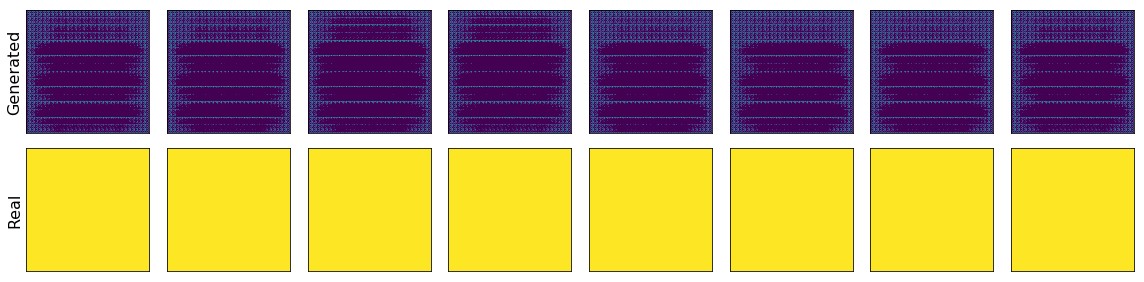

[0/100][15/40][3] Loss_D: -1.401310 Loss_G: 2.214915 Loss_D_real: -0.211205 Loss_D_fake 1.190105
[0/100][20/40][4] Loss_D: -1.340434 Loss_G: 1.706900 Loss_D_real: -1.110964 Loss_D_fake 0.229470


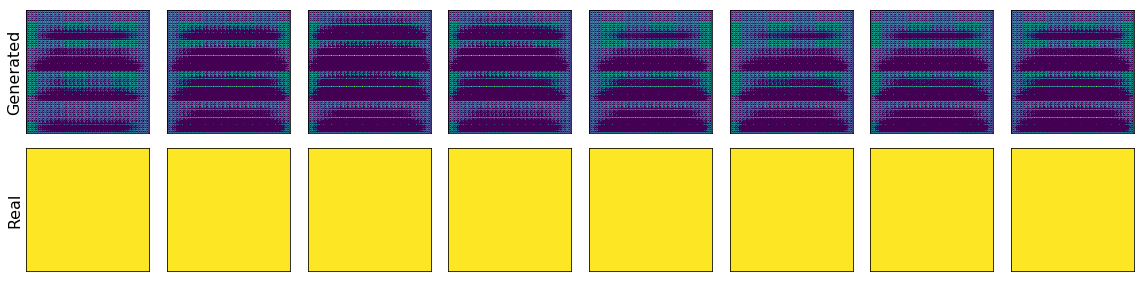

[0/100][25/40][5] Loss_D: -2.518938 Loss_G: 3.234226 Loss_D_real: -1.243662 Loss_D_fake 1.275276


In [ ]:
# setup optimizer
#optimizerD = optim.RMSprop(netD.parameters(), lr = lrD)
#optimizerG = optim.RMSprop(netG.parameters(), lr = lrG)


optimizerD = optim.Adam(netD.parameters(), lr=lrD, betas=(0.5, 0.9))
optimizerG = optim.Adam(netG.parameters(), lr=lrG, betas=(0.5, 0.9))

#optimizerD  = optim.Adam(netD.parameters(), lr=1e-3, betas=(0.9, 0.999))
#optimizerG = optim.Adam(netG.parameters(), lr=1e-3, betas=(0.9, 0.999))

wass_loss=[]
errG_l=[]
errD_real_l=[]
errD_fake_l=[]

input = torch.FloatTensor(batchSize, 1, s_sample, s_sample)
noise = torch.FloatTensor(batchSize, nz,1 , 1, device=device).normal_(0,1)
fixed_noise = torch.FloatTensor(batchSize, nz, 1, 1 ).normal_(0, 1)
#fixed_noise = torch.FloatTensor(1, nz, 1, 1,1).normal_(0, 1)

one = torch.FloatTensor([1])
#one = torch.tensor(1, dtype=torch.float)
mone = one * -1

#torch.cuda.empty_cache()
if cuda==True:
    netD.cuda()
    netG.cuda()
    input = input.cuda()
    one, mone = one.cuda(), mone.cuda()
    noise, fixed_noise = noise.cuda(), fixed_noise.cuda()


gen_iterations = 0
for epoch in range(niter):
    
    data_iter = iter(dataloader)
    i = 0
    while i < len(dataloader):
        
        ############################
        # (1) Update D network
        ###########################
        for p in netD.parameters(): # reset requires_grad
            p.requires_grad = True # they are set to False below in netG update
            
        j=0
        while j < Diters and i < len(dataloader):
            j += 1
            
            #clamp parameters to a cube
            for p in netD.parameters():
                p.data.clamp_(clamp_lower, clamp_upper)
                
            data=data_iter.next()
            #print(data.shape)
            i+=1
            
            real_cpu= data
            netD.zero_grad()
          
            batch_size=real_cpu.size(0)
            if cuda==True:
                real_cpu=real_cpu.cuda()
        
            input.resize_as_(real_cpu).copy_(real_cpu)
            inputv = Variable(input)
            #print(inputv.size())   
            errD_real=netD(inputv)
            
            errD_real.backward(one)
                
            #Train with fake
            noise.resize_(batchSize, nz, 1, 1).normal_(0, 0.33)

            with torch.no_grad():
                noisev = Variable(noise) # totally freeze netG
                
            fake = Variable(netG(noisev).data)

            inputv=fake
               
            errD_fake = netD(inputv)
            errD_fake.backward(mone)
            
            ## train with gradient penalty
            #radient_penalty = calc_gradient_penalty(netD, inputv.data, fake.data)
            #gradient_penalty.backward()
            #errD = errD_real - errD_fake + gradient_penalty
            
            errD = errD_real - errD_fake
            
            wass_loss.append(float(errD.data[0]))
            errD_real_l.append(float(errD_real.data[0]))
            errD_fake_l.append(float(errD_fake.data[0]))
            
            optimizerD.step()
           
        ############################
        # (2) Update G network
        ###########################
        #print('Updating G')
        for p in netD.parameters():
            p.requires_grad = False # to avoid computation
        netG.zero_grad()
        # in case our last batch was the tail batch of the dataloader,
        # make sure we feed a full batch of noise
        noise.resize_(batchSize, nz, 1, 1).normal_(0, 0.33)
        noisev = Variable(noise)
        fake = netG(noisev)
        #print('G:',fake.shape)
        errG = netD(fake)
        
        #print('errG: ', errG)
        #label = torch.full(size = (batch_size,), fill_value = real_label, device = device)
        errG.backward(one)
        optimizerG.step()
        
        gen_iterations += 1
        
        print('[%d/%d][%d/%d][%d] Loss_D: %f Loss_G: %f Loss_D_real: %f Loss_D_fake %f'
            % (epoch, niter, i, len(dataloader), gen_iterations,
            errD.data[0], errG.data[0], errD_real.data[0], errD_fake.data[0]))
        
        #wass_loss.append(float(errD.data[0]))
        errG_l.append(float(errG.data[0]))

        #if gen_iterations % 10==0  or (gen_iterations>5 and -float(errD.data[0])< min([-z for z in wass_loss])):
        if gen_iterations % 2 == 0:
            with torch.no_grad():
                fake = netG(Variable(fixed_noise))

            #plot_power_spec(np.array(real_cpu)*std_5, np.array(fake)*std_5, 14592.24, s_sample)
            visualize2d(np.exp(np.array(real_cpu)), np.exp(np.array(fake)), save='')
            #visualize2d(np.array(real_cpu)*std_5+mean_5, np.array(fake)*std_5+mean_5 , save='')
            '''
            mean_f, mean_r=[],[]
            for n in range(fake.size()[0]):
                mean_f.append(float(fake[n][0].mean()))
                mean_r.append(float(real_cpu[n][0].mean()))
            
            plot_loss(wass_loss,'Wasserstein loss', log_=False)
            hist_plot(fake.detach(), real_cpu, True, '.' )
            plot_means(mean_r,  mean_f)
            
            
            fake_s=fake[m][0]
            fake_s=np.array(fake_s.detach())
            #fake_s=np.array(fake_s.detach())
            #print(fake_s.size)
            print('Mass fake:', int(fake_s.sum()),'// Non-Zero %: ',
                  round(np.count_nonzero(np.array(fake_s.flatten()))/ len(np.array(fake_s.flatten())),3))
            
            real_s=np.array((real_cpu[m][0].detach()))
            #print('size real', real_s.shape)
            print('Mass real:', int(real_s.sum()),'// Non-Zero %: ', 
                  round(np.count_nonzero(real_s.flatten())/ len(real_s.flatten()),3))
             '''
            #plot_densities(np.array(real_cpu.detach())*std_5+mean_5, np.array(fake*std_5+mean_5), log_=True)
            
            #print('---------------------------------------------------------------------------------------')
            
        #    real_cpu = real_cpu.mul(0.5).add(0.5)
         #   vutils.save_image(real_cpu, '{0}/real_samples.png'.format(opt.experiment))
            
           # fake.data = fake.data.mul(0.5).add(0.5)
            #vutils.save_image(fake.data, '{0}/fake_samples_{1}.png'.format(experiment, gen_iterations))

    # do checkpointing
    torch.save(netG.state_dict(), '{0}/netG_epoch_{1}.pth'.format(experiment, epoch))
    torch.save(netD.state_dict(), '{0}/netD_epoch_{1}.pth'.format(experiment, epoch))

In [1]:
plot_loss(wass_loss,'Wasserstein loss', log_=False)

NameError: name 'plot_loss' is not defined

# Additional Architectures
## MLP

In [ ]:
#Atakans architecture

In [8]:
from conv_utils import calculate_conv_output_dim, calculate_pool_output_dim

# input: batch_size * nc * 64 * 64
# output: batch_size * k * 1 * 1
class N_Disc(nn.Module):
    def __init__(self, cube_dimension, fc1_hidden_dim, fc2_output_dim, 
                embedding_dim, leakyrelu_const, pool_return_indices):        
        super(N_Disc, self).__init__()

        self.pool_return_indices = pool_return_indices
      
        # First Convolutional Layer
        self.conv1_in_channels = 1
        self.conv1_out_channels = 2
        self.conv1_kernel = 3
        self.conv1_stride = 1
        self.conv1_padding = 0
        conv1_output_dim = calculate_conv_output_dim(D=cube_dimension,
                                        K=self.conv1_kernel,
                                        P=self.conv1_padding,
                                        S=self.conv1_stride)
        print("Conv1 Output Dimension = " + str(conv1_output_dim))
        self.conv1_encode = nn.Conv3d(in_channels=self.conv1_in_channels, 
                                    out_channels=self.conv1_out_channels, 
                                    kernel_size=self.conv1_kernel, 
                                    stride =self.conv1_stride, 
                                    padding=self.conv1_padding)     
        nn.init.xavier_uniform_(self.conv1_encode.weight)
        self.bn1_encode = nn.BatchNorm3d(num_features = self.conv1_out_channels)
        self.leakyrelu1 = nn.LeakyReLU(leakyrelu_const, inplace=True)

        # First Average Pooling
        self.pool1_kernel = 2
        self.pool1_stride = 2 
        pool1_output_dim = calculate_pool_output_dim(D=conv1_output_dim,
                                                    K=self.pool1_kernel,
                                                    S=self.pool1_stride)
        print("Pool1 Output Dimension = " + str(pool1_output_dim)) 
        self.pool1_encode = nn.MaxPool3d(kernel_size=self.pool1_kernel, 
                                            stride=self.pool1_stride,
                                            return_indices = self.pool_return_indices)

        # Second Convolutional Layer
        self.conv2_in_channels = self.conv1_out_channels
        self.conv2_out_channels = 12
        self.conv2_kernel = 4
        self.conv2_stride = 1
        self.conv2_padding = 0
        conv2_output_dim = calculate_conv_output_dim(D=pool1_output_dim,
                                        K=self.conv2_kernel,
                                        P=self.conv2_padding,
                                        S=self.conv2_stride)
        print("Conv2 Output Dimension= " + str(conv2_output_dim))
        self.conv2_encode = nn.Conv3d(in_channels=self.conv2_in_channels, 
                                    out_channels=self.conv2_out_channels, 
                                    kernel_size=self.conv2_kernel, 
                                    stride =self.conv2_stride, 
                                    padding=self.conv2_padding)     
        nn.init.xavier_uniform_(self.conv2_encode.weight)  
        self.bn2_encode = nn.BatchNorm3d(num_features = self.conv2_out_channels)
        self.leakyrelu2 = nn.LeakyReLU(leakyrelu_const, inplace=True)

        # Second Average Pooling
        self.pool2_kernel = 2
        self.pool2_stride = 2 
        pool2_output_dim = calculate_pool_output_dim(D=conv2_output_dim,
                                                K=self.pool2_kernel,
                                                S=self.pool2_stride)
        print("Pool2 Output Dimension = " + str(pool2_output_dim)) 
        self.pool2_encode = nn.MaxPool3d(kernel_size=self.pool2_kernel, 
                                            stride=self.pool2_stride,
                                            return_indices = self.pool_return_indices)   

        # Third Convolutional Layer
        self.conv3_in_channels = self.conv2_out_channels
        self.conv3_out_channels = 24
        self.conv3_kernel = 3
        self.conv3_stride = 1
        self.conv3_padding = 0
        conv3_output_dim = calculate_conv_output_dim(D=pool2_output_dim,
                                        K=self.conv3_kernel,
                                        P=self.conv3_padding,
                                        S=self.conv3_stride)
        print("Conv3 Output Dimension= " + str(conv3_output_dim))
        self.conv3_encode = nn.Conv3d(in_channels=self.conv3_in_channels, 
                                    out_channels=self.conv3_out_channels, 
                                    kernel_size=self.conv3_kernel, 
                                    stride =self.conv3_stride, 
                                    padding=self.conv3_padding)     
        nn.init.xavier_uniform_(self.conv3_encode.weight)
        self.bn3_encode = nn.BatchNorm3d(num_features = self.conv3_out_channels)
        self.leakyrelu3 = nn.LeakyReLU(leakyrelu_const, inplace=True)  

        # Third Average Pooling
        self.pool3_kernel = 2
        self.pool3_stride = 2 
        pool3_output_dim = calculate_pool_output_dim(D=conv3_output_dim,
                                                K=self.pool3_kernel,
                                                S=self.pool3_stride)
        print("Pool3 Output Dimension = " + str(pool3_output_dim)) 
        self.pool3_encode = nn.MaxPool3d(kernel_size=self.pool3_kernel, 
                                            stride=self.pool3_stride,
                                            return_indices = self.pool_return_indices)  

        # Fourth Convolutional Layer
        self.conv4_in_channels = self.conv3_out_channels
        self.conv4_out_channels = 32
        self.conv4_kernel = 4
        self.conv4_stride = 2
        self.conv4_padding = 0
        conv4_output_dim = calculate_conv_output_dim(D=pool3_output_dim,
                                        K=self.conv4_kernel,
                                        P=self.conv4_padding,
                                        S=self.conv4_stride)
        print("Conv4 Output Dimension= " + str(conv4_output_dim))
        self.conv4_encode = nn.Conv3d(in_channels=self.conv4_in_channels, 
                                    out_channels=self.conv4_out_channels, 
                                    kernel_size=self.conv4_kernel, 
                                    stride =self.conv4_stride, 
                                    padding=self.conv4_padding)     
        nn.init.xavier_uniform_(self.conv4_encode.weight) 
        self.bn4_encode = nn.BatchNorm3d(num_features = self.conv4_out_channels)
        self.leakyrelu4 = nn.LeakyReLU(leakyrelu_const, inplace=True)       

        # Fifth Convolutional Layer
        self.conv5_in_channels = self.conv4_out_channels
        self.conv5_out_channels = 64
        self.conv5_kernel = 3
        self.conv5_stride = 1
        self.conv5_padding = 0
        conv5_output_dim = calculate_conv_output_dim(D=conv4_output_dim,
                                        K=self.conv5_kernel,
                                        P=self.conv5_padding,
                                        S=self.conv5_stride)
        print("Conv5 Output Dimension= " + str(conv5_output_dim))
        self.conv5_encode = nn.Conv3d(in_channels=self.conv5_in_channels, 
                                    out_channels=self.conv5_out_channels, 
                                    kernel_size=self.conv5_kernel, 
                                    stride =self.conv5_stride, 
                                    padding=self.conv5_padding)     
        nn.init.xavier_uniform_(self.conv5_encode.weight) 
        self.bn5_encode = nn.BatchNorm3d(num_features = self.conv5_out_channels)
        self.leakyrelu5 = nn.LeakyReLU(leakyrelu_const, inplace=True)

        # Sixth Convolutional Layer
        self.conv6_in_channels = self.conv5_out_channels
        self.conv6_out_channels = 128
        self.conv6_kernel = 2
        self.conv6_stride = 1
        self.conv6_padding = 0
        conv6_output_dim = calculate_conv_output_dim(D=conv5_output_dim,
                                        K=self.conv6_kernel,
                                        P=self.conv6_padding,
                                        S=self.conv6_stride)
        print("Conv6 Output Dimension= " + str(conv6_output_dim))
        self.conv6_encode = nn.Conv3d(in_channels=self.conv6_in_channels, 
                                    out_channels=self.conv6_out_channels, 
                                    kernel_size=self.conv6_kernel, 
                                    stride =self.conv6_stride, 
                                    padding=self.conv6_padding)     
        nn.init.xavier_uniform_(self.conv6_encode.weight) 
        self.bn6_encode = nn.BatchNorm3d(num_features = self.conv6_out_channels)
        self.leakyrelu6 = nn.LeakyReLU(leakyrelu_const, inplace=True)

        # 7th Convolutional Layer
        self.conv7_in_channels = self.conv6_out_channels
        self.conv7_out_channels = 1
        self.conv7_kernel = 2
        self.conv7_stride = 2
        self.conv7_padding = 0
        conv7_output_dim = calculate_conv_output_dim(D=conv6_output_dim,
                                        K=self.conv7_kernel,
                                        P=self.conv7_padding,
                                        S=self.conv7_stride)
        print("Conv7 Output Dimension= " + str(conv7_output_dim))
        
        self.conv7_encode = nn.Conv3d(in_channels=self.conv7_in_channels, 
                                    out_channels=self.conv7_out_channels, 
                                    kernel_size=self.conv7_kernel, 
                                    stride =self.conv7_stride, 
                                    padding=self.conv7_padding)     
        
        nn.init.xavier_uniform_(self.conv7_encode.weight) 
        #self.bn7_encode = nn.BatchNorm3d(num_features = self.conv7_out_channels)
        
        #self.leakyrelu7 = nn.LeakyReLU(leakyrelu_const, inplace=True)
     
    #         # 1st FC Layer
#         self.fc1_in_features = self.conv7_out_channels * conv7_output_dim**3
#         self.fc1_encode = nn.Linear(in_features=self.fc1_in_features,
#                                     out_features=fc1_hidden_dim)
#         self.leakyrelu8 = nn.LeakyReLU(leakyrelu_const, inplace=True)

#         # 2nd FC Layer
#         self.fc2_encode = nn.Linear(in_features=self.fc1_hidden_dim,
#                                     out_features=embedding_dim)
#         self.relu1 = nn.ReLU(inplace=True)

    def forward(self, input):
        
        # Convolution Layers
#         print("Input = " +str(input.shape))
        out = self.conv1_encode(input)
#         print("conv1_encode = " + str(out.shape))
        out = self.pool1_encode(out)
#         print("pool1_encode = " + str(out.shape))
        out = self.bn1_encode(out) 
        out = self.leakyrelu1(out)

        out = self.conv2_encode(out)
#         print("conv2_encode = " + str(out.shape))
        out = self.pool2_encode(out)
#         print("pool2_encode = " + str(out.shape))
        out = self.bn2_encode(out) 
        out = self.leakyrelu2(out)

        out = self.conv3_encode(out)
#         print("conv3_encode = " + str(out.shape))
        out = self.pool3_encode(out)
#         print("pool3_encode = " + str(out.shape))
        out = self.bn3_encode(out) 
        out = self.leakyrelu3(out)

        out = self.conv4_encode(out)
#         print("conv4_encode = " + str(out.shape))
        out = self.bn4_encode(out) 
        out = self.leakyrelu4(out)

        out = self.conv5_encode(out)
#         print("conv5_encode = " + str(out.shape))
        out = self.bn5_encode(out) 
        out = self.leakyrelu5(out)

        out = self.conv6_encode(out)
#         print("conv6_encode = " + str(out.shape))
        out = self.bn6_encode(out) 
        out = self.leakyrelu6(out)
        
        out = self.conv7_encode(out)
#         print("conv7_encode = " + str(out.shape))
        #out = self.bn7_encode(out) 
        #out = self.leakyrelu7(out)
        
#         print("out = " + str(out.shape))

#         # Transform
        print('D last', out.shape)
        

        #out = out.view(batchSize, -1)

#         # FC Layers
#         out = self.fc1_encode(out)
#         out = self.leakyrelu8(out)

#         out = self.fc2_encode(out)
#         out = self.relu1(out)        
        out= out.mean(0)
        return out.view(1)

In [20]:
from conv_utils import calculate_deconv_output_dim

# input: batch_size * k * 1 * 1
# output: batch_size * nc * image_size * image_size
class N_Gen(nn.Module):
    def __init__(self, embedded_cube_dimension,fc1_hidden_dim, fc2_output_dim, 
                embedding_dim, leakyrelu_const):
        super(N_Gen, self).__init__()

#         # 1st FC Layer
#         self.embedding_dim = embedding_dim
#         self.fc1_in_features = self.embedding_dim 
#         self.fc1_hidden_dim = fc1_hidden_dim
#         self.fc1_decode = nn.Linear(in_features=self.fc1_in_features,
#                                     out_features=self.fc1_hidden_dim)
#         self.leakyrelu1 = nn.LeakyReLU(leakyrelu_const, inplace=True)

#         # 2nd FC Layer
#         self.fc2_output_dim = fc2_output_dim
#         self.fc2_decode = nn.Linear(in_features=self.fc1_hidden_dim,
#                                     out_features=self.fc2_output_dim )
#         self.leakyrelu2 = nn.LeakyReLU(leakyrelu_const, inplace=True)

        # 1st Deconvolutional Layer
        self.deconv1_in_channels = batch_size
        self.deconv1_out_channels = 128
        self.deconv1_kernel = 2
        self.deconv1_stride = 1
        self.deconv1_padding = 0
        deconv1_output_dim = calculate_deconv_output_dim(D=embedded_cube_dimension,
                                        K=self.deconv1_kernel,
                                        P=self.deconv1_padding,
                                        S=self.deconv1_stride)
        print("Deconv1 Output Dimension = " + str(deconv1_output_dim))
        self.deconv1_decode = nn.ConvTranspose3d(in_channels=self.deconv1_in_channels, 
                                    out_channels=self.deconv1_out_channels, 
                                    kernel_size=self.deconv1_kernel, 
                                    stride =self.deconv1_stride, 
                                    padding=self.deconv1_padding)     
        nn.init.xavier_uniform_(self.deconv1_decode.weight)
        self.bn1_decode = nn.BatchNorm3d(num_features = self.deconv1_out_channels)
        self.leakyrelu1 = nn.LeakyReLU(leakyrelu_const, inplace=True)

        # 2nd Deconvolutional Layer
        self.deconv2_in_channels = self.deconv1_out_channels
        self.deconv2_out_channels = 64
        self.deconv2_kernel = 2
        self.deconv2_stride = 1
        self.deconv2_padding = 0
        deconv2_output_dim = calculate_deconv_output_dim(D=deconv1_output_dim,
                                        K=self.deconv2_kernel,
                                        P=self.deconv2_padding,
                                        S=self.deconv2_stride)
        print("Deconv2 Output Dimension = " + str(deconv2_output_dim))
        self.deconv2_decode = nn.ConvTranspose3d(in_channels=self.deconv2_in_channels, 
                                    out_channels=self.deconv2_out_channels, 
                                    kernel_size=self.deconv2_kernel, 
                                    stride =self.deconv2_stride, 
                                    padding=self.deconv2_padding)     
        nn.init.xavier_uniform_(self.deconv2_decode.weight)
        self.bn2_decode = nn.BatchNorm3d(num_features = self.deconv2_out_channels)
        self.leakyrelu2 = nn.LeakyReLU(leakyrelu_const, inplace=True)
        
        # 3rd Deconvolutional Layer
        self.deconv3_in_channels = self.deconv2_out_channels
        self.deconv3_out_channels = 32
        self.deconv3_kernel = 3
        self.deconv3_stride = 1
        self.deconv3_padding = 0
        deconv3_output_dim = calculate_deconv_output_dim(D=deconv2_output_dim,
                                        K=self.deconv3_kernel,
                                        P=self.deconv3_padding,
                                        S=self.deconv3_stride)
        print("Deconv3 Output Dimension = " + str(deconv3_output_dim))
        self.deconv3_decode = nn.ConvTranspose3d(in_channels=self.deconv3_in_channels, 
                                    out_channels=self.deconv3_out_channels, 
                                    kernel_size=self.deconv3_kernel, 
                                    stride =self.deconv3_stride, 
                                    padding=self.deconv3_padding)     
        nn.init.xavier_uniform_(self.deconv3_decode.weight)
        self.bn3_decode = nn.BatchNorm3d(num_features = self.deconv3_out_channels)
        self.leakyrelu3 = nn.LeakyReLU(leakyrelu_const, inplace=True)
        
        # 4th Deconvolutional Layer
        self.deconv4_in_channels = self.deconv3_out_channels
        self.deconv4_out_channels = 24
        self.deconv4_kernel = 4
        self.deconv4_stride = 2
        self.deconv4_padding = 0
        deconv4_output_dim = calculate_deconv_output_dim(D=deconv3_output_dim,
                                        K=self.deconv4_kernel,
                                        P=self.deconv4_padding,
                                        S=self.deconv4_stride)
        print("Deconv4 Output Dimension = " + str(deconv4_output_dim))
        self.deconv4_decode = nn.ConvTranspose3d(in_channels=self.deconv4_in_channels, 
                                    out_channels=self.deconv4_out_channels, 
                                    kernel_size=self.deconv4_kernel, 
                                    stride =self.deconv4_stride, 
                                    padding=self.deconv4_padding)     
        nn.init.xavier_uniform_(self.deconv4_decode.weight)
        self.bn4_decode = nn.BatchNorm3d(num_features = self.deconv4_out_channels)
        self.leakyrelu4 = nn.LeakyReLU(leakyrelu_const, inplace=True)
        
        # Avg Unpooling 1
        # Just make 1 voxel to 8 voxels of 2-len edges
        # Implemented in forward pass
        self.avgunpool1_scale = 2
        self.avgunpool1 = nn.Upsample(scale_factor = self.avgunpool1_scale, mode='nearest')
        
        
        # 5th Deconvolutional Layer
        self.deconv5_in_channels = self.deconv4_out_channels
        self.deconv5_out_channels = 12
        self.deconv5_kernel = 3
        self.deconv5_stride = 1
        self.deconv5_padding = 0
        deconv5_output_dim = calculate_deconv_output_dim(D=deconv4_output_dim * self.avgunpool1_scale,
                                        K=self.deconv5_kernel,
                                        P=self.deconv5_padding,
                                        S=self.deconv5_stride)
        print("Deconv5 Output Dimension = " + str(deconv5_output_dim))
        self.deconv5_decode = nn.ConvTranspose3d(in_channels=self.deconv5_in_channels, 
                                    out_channels=self.deconv5_out_channels, 
                                    kernel_size=self.deconv5_kernel, 
                                    stride =self.deconv5_stride, 
                                    padding=self.deconv5_padding)     
        nn.init.xavier_uniform_(self.deconv5_decode.weight)
        self.bn5_decode = nn.BatchNorm3d(num_features = self.deconv5_out_channels)
        self.leakyrelu5 = nn.LeakyReLU(leakyrelu_const, inplace=True)
        
        # Avg Unpooling 2
        # Just make 1 voxel to 8 voxels of 2-len edges
        # Implemented in forward pass
        self.avgunpool2_scale = 2
        self.avgunpool2 = nn.Upsample(scale_factor = self.avgunpool2_scale, mode='nearest')
        
        # 6th Deconvolutional Layer
        self.deconv6_in_channels = self.deconv5_out_channels
        self.deconv6_out_channels = 2
        self.deconv6_kernel = 4
        self.deconv6_stride = 1
        self.deconv6_padding = 0
        deconv6_output_dim = calculate_deconv_output_dim(D=deconv5_output_dim * self.avgunpool2_scale,
                                        K=self.deconv6_kernel,
                                        P=self.deconv6_padding,
                                        S=self.deconv6_stride)
        print("Deconv6 Output Dimension = " + str(deconv6_output_dim))
        self.deconv6_decode = nn.ConvTranspose3d(in_channels=self.deconv6_in_channels, 
                                    out_channels=self.deconv6_out_channels, 
                                    kernel_size=self.deconv6_kernel, 
                                    stride =self.deconv6_stride, 
                                    padding=self.deconv6_padding)     
        nn.init.xavier_uniform_(self.deconv6_decode.weight)
        self.bn6_decode = nn.BatchNorm3d(num_features = self.deconv6_out_channels)
        self.leakyrelu6 = nn.LeakyReLU(leakyrelu_const, inplace=True)
        
        # Avg Unpooling 3
        # Just make 1 voxel to 8 voxels of 2-len edges
        # Implemented in forward pass
        self.avgunpool3_scale = 2
        self.avgunpool3 = nn.Upsample(scale_factor = self.avgunpool3_scale, mode='nearest')
        
        # 7th Deconvolutional Layer
        self.deconv7_in_channels = self.deconv6_out_channels
        self.deconv7_out_channels = 1
        self.deconv7_kernel = 3
        self.deconv7_stride = 1
        self.deconv7_padding = 0
        deconv7_output_dim = calculate_deconv_output_dim(D=deconv6_output_dim * self.avgunpool3_scale,
                                        K=self.deconv7_kernel,
                                        P=self.deconv7_padding,
                                        S=self.deconv7_stride)
        print("Deconv7 Output Dimension = " + str(deconv7_output_dim))
        self.deconv7_decode = nn.ConvTranspose3d(in_channels=self.deconv7_in_channels, 
                                    out_channels=self.deconv7_out_channels, 
                                    kernel_size=self.deconv7_kernel, 
                                    stride =self.deconv7_stride, 
                                    padding=self.deconv7_padding)     
        nn.init.xavier_uniform_(self.deconv7_decode.weight)
        self.bn7_decode = nn.BatchNorm3d(num_features = self.deconv7_out_channels)
#         self.leakyrelu7 = nn.LeakyReLU(leakyrelu_const, inplace=True)
        
        # For data in [0,1]
#         self.relu7 = nn.ReLU(inplace=True)     
        # For data in [-1,1]
        self.tanh7 = nn.Tanh()     

    def forward(self, input):
#         print("\nDecoder - Forward Pass")
        
        # Deconvolution Layers
#         print("Input = " +str(input.shape))
        out = self.deconv1_decode(input)
#         print("deconv1_decode = " + str(out.shape))
        out = self.bn1_decode(out)
        out = self.leakyrelu1(out)

        out = self.deconv2_decode(out)
#         print("deconv2_decode = " + str(out.shape))
        out = self.bn2_decode(out)
        out = self.leakyrelu2(out)
        
        out = self.deconv3_decode(out)
#         print("deconv3_decode = " + str(out.shape))
        out = self.bn3_decode(out)
        out = self.leakyrelu3(out)
        
        out = self.deconv4_decode(out)
#         print("deconv4_decode = " + str(out.shape))
        out = self.bn4_decode(out)
        out = self.leakyrelu4(out)
        out = self.avgunpool1(out)
#         print("avgunpool1 = " + str(out.shape))

        out = self.deconv5_decode(out)
#         print("deconv5_decode = " + str(out.shape))
        out = self.bn5_decode(out)
        out = self.leakyrelu5(out)
        out = self.avgunpool2(out)
#         print("avgunpool2 = " + str(out.shape))
        out = self.deconv6_decode(out)
#         print("deconv6_decode = " + str(out.shape))
        out = self.bn6_decode(out)
        out = self.leakyrelu6(out)
        out = self.avgunpool3(out) 
#         print("avgunpool3 = " + str(out.shape))
        
        out = self.deconv7_decode(out)
#         print("deconv7_decode = " + str(out.shape))
        out = self.bn7_decode(out)
#         out = self.leakyrelu7(out)
#         out = self.relu7(out) # for [0,1]
        out = self.tanh7(out) # for [-1,1]
        
#         print("decoder out = " + str(out.shape))
#         # Transformation
#         out = out.view(batch_size, nz, 1,1,1)
        
        return out

# DCGAN

In [7]:
class DCGAN_G__(nn.Module):
    def __init__(self, ngpu, cube_len, leak_value, bias):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.cube_len=cube_len
        self.leak_value=leak_value
        self.bias=bias
        
        self.main = nn.Sequential(
            #1
            nn.ConvTranspose3d(in_channels=nz, 
                      out_channels=self.cube_len*8, 
                      kernel_size=4, # == 4( 4,4,4)
                      stride = 2, # == 2
                     #padding=(1,1,1), # == 1
                      padding=0,
                      bias=self.bias),
            nn.BatchNorm3d(self.cube_len*8),
            nn.ReLU(True),
            
            #2
            nn.ConvTranspose3d(self.cube_len*8, self.cube_len*4, kernel_size=4, stride=2, bias=self.bias, padding=1),
            nn.BatchNorm3d(self.cube_len*4),
            nn.ReLU(True),
            
            #3
            nn.ConvTranspose3d(self.cube_len*4, self.cube_len*2, kernel_size=4, stride=2, bias=self.bias, padding=1),
            nn.BatchNorm3d(self.cube_len*2),
            nn.ReLU(True),
            
            #4
            nn.ConvTranspose3d(self.cube_len*2, self.cube_len, kernel_size=4, stride=2, bias=self.bias, padding=1),
            nn.BatchNorm3d(self.cube_len),
            nn.ReLU(True),
            
            #5 
            nn.ConvTranspose3d(self.cube_len, 1, kernel_size=4, stride=2, bias=self.bias, padding=1)
            
            )    
        
    def forward(self, input):
        if input.is_cuda and self.ngpu > 1:
            output = nn.parallel.data_parallel(self.main, input, range(self.ngpu))
        else:
            output = self.main(input)
        return output

In [8]:
class DCGAN_G(nn.Module):
    def __init__(self, ngpu,kernel, bias, dilation):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.kernel=kernel
        self.bias=bias
        self.dilation=dilation
        self.main = nn.Sequential(
            # input is Z,
            nn.ConvTranspose3d(in_channels=nz,
                               out_channels=ngf * 16,
                               kernel_size =self.kernel,
                               stride = 1,
                               padding = 0,
                               bias=False,
                              dilation=self.dilation),
            nn.BatchNorm3d(ngf * 16),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose3d(ngf * 16, ngf * 8, self.kernel, 2, 1, bias=self.bias, dilation=self.dilation),
            nn.BatchNorm3d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose3d(ngf * 8, ngf * 4, self.kernel, 2, 1, bias=self.bias,dilation=self.dilation),
            nn.BatchNorm3d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose3d(ngf * 4, ngf * 2, self.kernel, 2, 1, bias=self.bias,dilation=self.dilation),
            nn.BatchNorm3d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose3d(ngf * 2,     ngf, self.kernel, 2, 1, bias=self.bias,dilation=self.dilation),
            nn.BatchNorm3d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose3d(ngf, nc, self.kernel, 2, 1, bias=self.bias,dilation=self.dilation),
            #nn.Tanh(),
            nn.ReLU(True)
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        if input.is_cuda and self.ngpu > 1:
            output = nn.parallel.data_parallel(self.main, input, range(self.ngpu))
        else:
            output = self.main(input)
        #print('G: ' ,output.size())
        return output

In [10]:
class DCGAN_D__(nn.Module):
    def __init__(self, ngpu, cube_len, leak_value, bias):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.cube_len=cube_len
        self.leak_value=leak_value
        self.bias=bias
        
        self.main = nn.Sequential(
            #1
            nn.Conv3d(in_channels=1, 
                      out_channels=self.cube_len, 
                      kernel_size=4, # == 4( 4,4,4)
                      stride = 2, # == 2
                     padding=1,
                     # padding=0,
                      bias=self.bias),
            nn.BatchNorm3d(self.cube_len),
            nn.LeakyReLU(self.leak_value, inplace=True),
        
            #2
            nn.Conv3d(self.cube_len, self.cube_len*2, kernel_size=4, stride=2, bias=self.bias, padding=(1,1,1)),
            nn.BatchNorm3d(self.cube_len*2),
            nn.LeakyReLU(self.leak_value, inplace=True),
  
            
            #3
            nn.Conv3d(self.cube_len*2, self.cube_len*4, kernel_size=4, stride=2, bias=self.bias, padding=(1,1,1)),
            nn.BatchNorm3d(self.cube_len*4),
            nn.LeakyReLU(self.leak_value, inplace=True),
        
            #4
            nn.Conv3d(self.cube_len*4, self.cube_len*8, kernel_size=4, stride=2, bias=self.bias, padding=(1,1,1)),
            nn.BatchNorm3d(self.cube_len*8),
            nn.LeakyReLU(self.leak_value, inplace=True),
            
            #5
            nn.Conv3d(self.cube_len*8, self.cube_len*16, kernel_size=4, stride=2, bias=self.bias, padding=(1,1,1)),
            nn.BatchNorm3d(self.cube_len* 16),
            nn.LeakyReLU(self.leak_value, inplace=True),
            
            #6
            nn.Conv3d(self.cube_len*16, 1, kernel_size=4, stride=1, bias=self.bias, padding=0)
            
            )    
        
    def forward(self, input):
        if input.is_cuda and self.ngpu > 1:
            output = nn.parallel.data_parallel(self.main,  input, range(self.ngpu))
        else:
            output = self.main(input)
        #print('D0:',output.size)
        output = output.mean(0)
        #print('D1:',output.size)
        #return output.view(-1, 1).squeeze(1)
        return output.view(1)

In [11]:
#https://github.com/rimchang/3DGAN-Pytorch/blob/master/3D_GAN/model.py
'''Detect when wass loss is making a big jump and keep iterating the 
critic till the curve goes up again to roughly were it was before the jump.'''

class DCGAN_D(nn.Module):
    def __init__(self, ngpu, kernel, dilation, bias):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.kernel=kernel
        self.bias=bias
        self.dilation=dilation
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            # nc = number of channels
            
            nn.Conv3d(in_channels=nc, 
                      out_channels=ndf, 
                      kernel_size=self.kernel, # == 4( 4,4,4)
                      stride = 2, # == 2
                     padding=1,
                      dilation=self.dilation,
                      # == 1
                     # padding=0,
                      bias=self.bias),
            nn.LeakyReLU(0.2, inplace=True),
            
            # state size. (ndf) x 32 x 32
            nn.Conv3d(ndf, ndf * 2, self.kernel, 2, 1, bias=self.bias, dilation=self.dilation),
            nn.BatchNorm3d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            
            # state size. (ndf*2) x 16 x 16
            nn.Conv3d(ndf * 2, ndf * 4, self.kernel, 2, 1, bias=self.bias, dilation=self.dilation),
            nn.BatchNorm3d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            
            # state size. (ndf*4) x 8 x 8
            nn.Conv3d(ndf * 4, ndf * 8, self.kernel, 2, 1, bias=self.bias, dilation=self.dilation),
            nn.BatchNorm3d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            
            # state size. (ndf*4) x 8 x 8
            nn.Conv3d(ndf * 8, ndf * 16, self.kernel, 2, 1, bias=self.bias, dilation=self.dilation),
            nn.BatchNorm3d(ndf * 16),
            nn.LeakyReLU(0.2, inplace=True),
            
            # state size. (ndf*8) x 4 x 4
           # nn.Conv3d(ndf * 16, ndf*32, 4, 2, 1, bias=False),
            #nn.BatchNorm3d(ndf * 32),
            #nn.LeakyReLU(0.2, inplace=True),
            
            #Final conv (D does not have ti output a probability)
            nn.Conv3d(ndf*16, 1, self.kernel, 1, 0, bias=self.bias, dilation=self.dilation)
        )
        #self.main = main

    def forward(self, input):
        if input.is_cuda and self.ngpu > 1:
            output = nn.parallel.data_parallel(self.main,  input, range(self.ngpu))
        else:
            output = self.main(input)
            
        #print('D0:',output.size())
        output = output.mean(0)
        #return output.view(-1, 1).squeeze(1)
        #print('D1:',output.size())
        return output.view(1)
        '''self.main = main
        self.linear = nn.Linear(4*4*4*DIM, 1)

    def forward(self, input):
        output = self.main(input)
        output = output.view(-1, 4*4*4*DIM)
        output = self.linear(output)
        return output'''
    

In [ ]:
#Past
def visualize_cube(cube=None,      ## array name
             edge_dim=None,        ## edge dimension (128 for 128 x 128 x 128 cube)
             start_cube_index_x=0,
             start_cube_index_y=0,
             start_cube_index_z=0,
             fig_size=None,
             stdev_to_white=1,
             norm_multiply=600,
             color_map="Blues",
             lognormal=False):
    
    cube_size = edge_dim
    edge = np.array([*range(cube_size)])
    
    end_x = start_cube_index_x + cube_size
    end_y = start_cube_index_y + cube_size
    end_z = start_cube_index_z + cube_size
    
    fig = plt.figure(figsize=fig_size)
    ax = fig.add_subplot(111, projection='3d')
    
    data_value = cube[start_cube_index_x:end_x,
                      start_cube_index_y:end_y,
                      start_cube_index_z:end_z]
    
    x,y,z = edge,edge,edge
    product = [*itertools.product(x,y,z)]
    
    X = np.array([product[k][0] for k in [*range(len(product))]])
    Y = np.array([product[k][1] for k in [*range(len(product))]])
    Z = np.array([product[k][2] for k in [*range(len(product))]])
    
    ## map data to 1d array that corresponds to the axis values in the product array
    data_1dim = np.array([data_value[X[i]][Y[i]][Z[i]] for i in [*range(len(product))]])
    
    
#     initial_mean = np.mean(data_1dim) - stdev_to_white*np.std(data_1dim)
#     mask = data_1dim > initial_mean
#     mask = mask.astype(np.int)
    
#     data_1dim = np.multiply(mask,data_1dim)
    ## mask X,Y,Z to match the dimensions of the data
    X, Y, Z, data_1dim = [axis[np.where(data_1dim>0)] for axis in [X,Y,Z,data_1dim]]

    if lognormal == False:
        s = norm_multiply*data_1dim/np.linalg.norm(data_1dim)
    else:
        s = np.log(norm_multiply*data_1dim/np.linalg.norm(data_1dim))
    
    cmap=plt.get_cmap(color_map)
    new_cmap = truncate_colormap(cmap, 0.99, 1,n=10)
    
    ## IGNORE BELOW 3D PLOT FORMATTING 
    
    ## plot cube
    
    cube_definition = [(start_cube_index_x, start_cube_index_x, start_cube_index_x),
                      (start_cube_index_x, start_cube_index_x+edge_dim, start_cube_index_x),
                      (start_cube_index_x+edge_dim, start_cube_index_x, start_cube_index_x),
                      (start_cube_index_x, start_cube_index_x, start_cube_index_x+edge_dim)]
    
    cube_definition_array = [
        np.array(list(item))
        for item in cube_definition
    ]
    
    points = []
    points += cube_definition_array
    vectors = [
        cube_definition_array[1] - cube_definition_array[0],
        cube_definition_array[2] - cube_definition_array[0],
        cube_definition_array[3] - cube_definition_array[0]
    ]
    
    
    points += [cube_definition_array[0] + vectors[0] + vectors[1]]
    points += [cube_definition_array[0] + vectors[0] + vectors[2]]
    points += [cube_definition_array[0] + vectors[1] + vectors[2]]
    points += [cube_definition_array[0] + vectors[0] + vectors[1] + vectors[2]]

    points = np.array(points)

    edges = [
        [points[0], points[3], points[5], points[1]],
        [points[1], points[5], points[7], points[4]],
        [points[4], points[2], points[6], points[7]],
        [points[2], points[6], points[3], points[0]],
        [points[0], points[2], points[4], points[1]],
        [points[3], points[6], points[7], points[5]]
    ]
    
#     ax.fig.add_subplot(111, projection='3d')
    
    faces = Poly3DCollection(edges, linewidths=1, edgecolors='k',)
    faces.set_facecolor((0,0,1,0)) ## set transparent facecolor to the cube
    
    ax.add_collection3d(faces)
    
    ax.scatter(points[:,0], points[:,1], points[:,2], s=0)

    ax.set_aspect('equal')
    
    ax.xaxis.pane.fill = False
    ax.yaxis.pane.fill = False
    ax.zaxis.pane.fill = False
    
    ax.xaxis.pane.set_edgecolor('w')
    ax.yaxis.pane.set_edgecolor('w')
    ax.zaxis.pane.set_edgecolor('w')
    
    ax.xaxis.set_major_locator(MultipleLocator(edge_dim))
    ax.yaxis.set_major_locator(MultipleLocator(edge_dim))
    ax.zaxis.set_major_locator(MultipleLocator(edge_dim))
    
    ax.grid(False)
    
    ax.set_xlim3d(0,edge_dim)
    ax.set_ylim3d(0,edge_dim)
    ax.set_zlim3d(0,edge_dim)
#     ax.get_frame_on()
    
    ax.xaxis._axinfo['tick']['inward_factor'] = 0
    ax.xaxis._axinfo['tick']['outward_factor'] = 0
    ax.yaxis._axinfo['tick']['inward_factor'] = 0
    ax.yaxis._axinfo['tick']['outward_factor'] = 0
    ax.zaxis._axinfo['tick']['inward_factor'] = 0
    ax.zaxis._axinfo['tick']['outward_factor'] = 0
    
    ax.scatter(X, Y, Z,       ## axis vals
               c=data_1dim,   ## data, mapped to 1-dim
               cmap=new_cmap,
               s=s,           ## sizes - dims multiplied by each data point's magnitude
               alpha=0.7,
               edgecolors="face")
    
    
    
    plt.show()